# Импорт  

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
import optuna
import ast
import math 
import matplotlib.pyplot as plt
import scipy.stats as stats


# Подгрузка данных

In [2]:
train=pd.read_csv("train.csv", sep=';')
test=pd.read_csv("test.csv", sep=';')
refer_vectors=pd.read_csv("referer_vectors.csv", sep=';')
train_labels=pd.read_csv("train_labels.csv", sep=';')
geo_info=pd.read_csv("geo_info.csv", sep=';')

# Исследование данных

## Полезные функции

In [3]:
# Определение типа фичи
def feature_type_def(df):
  cat_columns =  df.select_dtypes("object").columns
  num_columns =  df.select_dtypes(include=['int64', 'float64']).columns
  return cat_columns, num_columns

## train и test



In [4]:
# Проверка структуры данных и наличия пропущенных значений
print(train.columns) # Вывод списка колонок
print(train.isna().sum()) # Подсчёт пропущенных значений
train.dropna(inplace=True) # Удаление строк с пропущенными значениями

Index(['request_ts', 'user_id', 'referer', 'geo_id', 'user_agent'], dtype='object')
request_ts    0
user_id       0
referer       0
geo_id        0
user_agent    1
dtype: int64


In [5]:
cat_columns, num_columns = feature_type_def(train)

array([[<Axes: title={'center': 'request_ts'}>,
        <Axes: title={'center': 'geo_id'}>]], dtype=object)

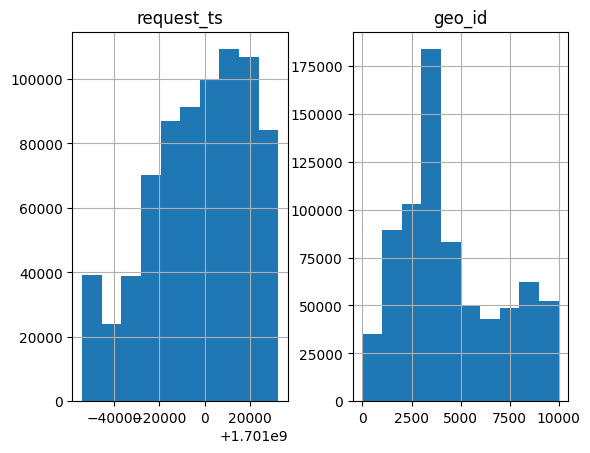

In [6]:
# Построение гистограмм для анализа распределения данных
train.hist()

In [7]:
# Объединение таблицы train с дополнительными данными
train = train.merge(refer_vectors, on='referer')
train.head()

,request_ts,user_id,referer,geo_id,user_agent,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9
0,1701011363,fb858e8e0a2bec074450eaf94b627fd3,https://9b48ee5/,4799,"{'browser': 'Chrome Mobile', 'browser_version'...",11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817
1,1700986581,46a5f128fd569c764a92c2eaa788095e,https://9b48ee5/,8257,"{'browser': 'Chrome Mobile', 'browser_version'...",11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817
2,1701011071,5a74e9ac53ffb21a20cce117c0ad77ba,https://9634fd0/1409e548,3150,"{'browser': 'Yandex Browser', 'browser_version...",12498,2451,10304,-6380,11608,3106,-2188,10573,3347,21870
3,1700992803,af735816ca19115431ae3d89518c8c91,https://9b48ee5/,2740,"{'browser': 'Chrome Mobile', 'browser_version'...",11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817
4,1701021666,364f0ae0a3f29a685c4fb5bae6033b9a,https://9b48ee5/,4863,"{'browser': 'Yandex Browser', 'browser_version...",11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817


In [8]:
train_labels.head()

,user_id,target
0,fb858e8e0a2bec074450eaf94b627fd3,0
1,46a5f128fd569c764a92c2eaa788095e,0
2,5a74e9ac53ffb21a20cce117c0ad77ba,0
3,af735816ca19115431ae3d89518c8c91,0
4,364f0ae0a3f29a685c4fb5bae6033b9a,0


In [9]:
# Объединение таблицы train с дополнительными данными
train = train.merge(train_labels, on='user_id')
train = train.merge(geo_info, on='geo_id')


In [10]:
train.shape

(601289, 19)

## Посмотрим на распределение значений в таргете

In [11]:
train["target"].value_counts()

target
0    313572
1    287717
Name: count, dtype: int64

In [12]:
train["target"]

0         0
1         0
2         0
3         0
4         0
         ..
601284    0
601285    0
601286    0
601287    1
601288    0
Name: target, Length: 601289, dtype: int64

# Извлечём из колонки user_agent дополнительные категориальные фичи

In [13]:
# Функция для безопасного преобразования строки в словарь
def safe_literal_eval(x):
    if pd.isna(x):
        return {}
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return {}

# Извлечение информации о браузере, ОС и их версиях
train['parsed_user_agent'] = train['user_agent'].apply(safe_literal_eval)

train['browser'] = train['parsed_user_agent'].apply(lambda x: x.get('browser', None))
train['browser_version'] = train['parsed_user_agent'].apply(lambda x: x.get('browser_version', None))
train['os'] = train['parsed_user_agent'].apply(lambda x: x.get('os', None))
train['os_version'] = train['parsed_user_agent'].apply(lambda x: x.get('os_version', None))

train.drop(columns=['parsed_user_agent'], inplace=True)

In [14]:
train.columns

Index(['request_ts', 'user_id', 'referer', 'geo_id', 'user_agent',
       'component0', 'component1', 'component2', 'component3', 'component4',
       'component5', 'component6', 'component7', 'component8', 'component9',
       'target', 'country_id', 'region_id', 'timezone_id', 'browser',
       'browser_version', 'os', 'os_version'],
      dtype='object')

In [15]:
train.isna().sum()

request_ts             0
user_id                0
referer                0
geo_id                 0
user_agent             0
component0             0
component1             0
component2             0
component3             0
component4             0
component5             0
component6             0
component7             0
component8             0
component9             0
target                 0
country_id             0
region_id          50620
timezone_id            0
browser                0
browser_version        0
os                     0
os_version             0
dtype: int64

In [16]:
train=train.dropna()

## Посмотрим на распределение фичей

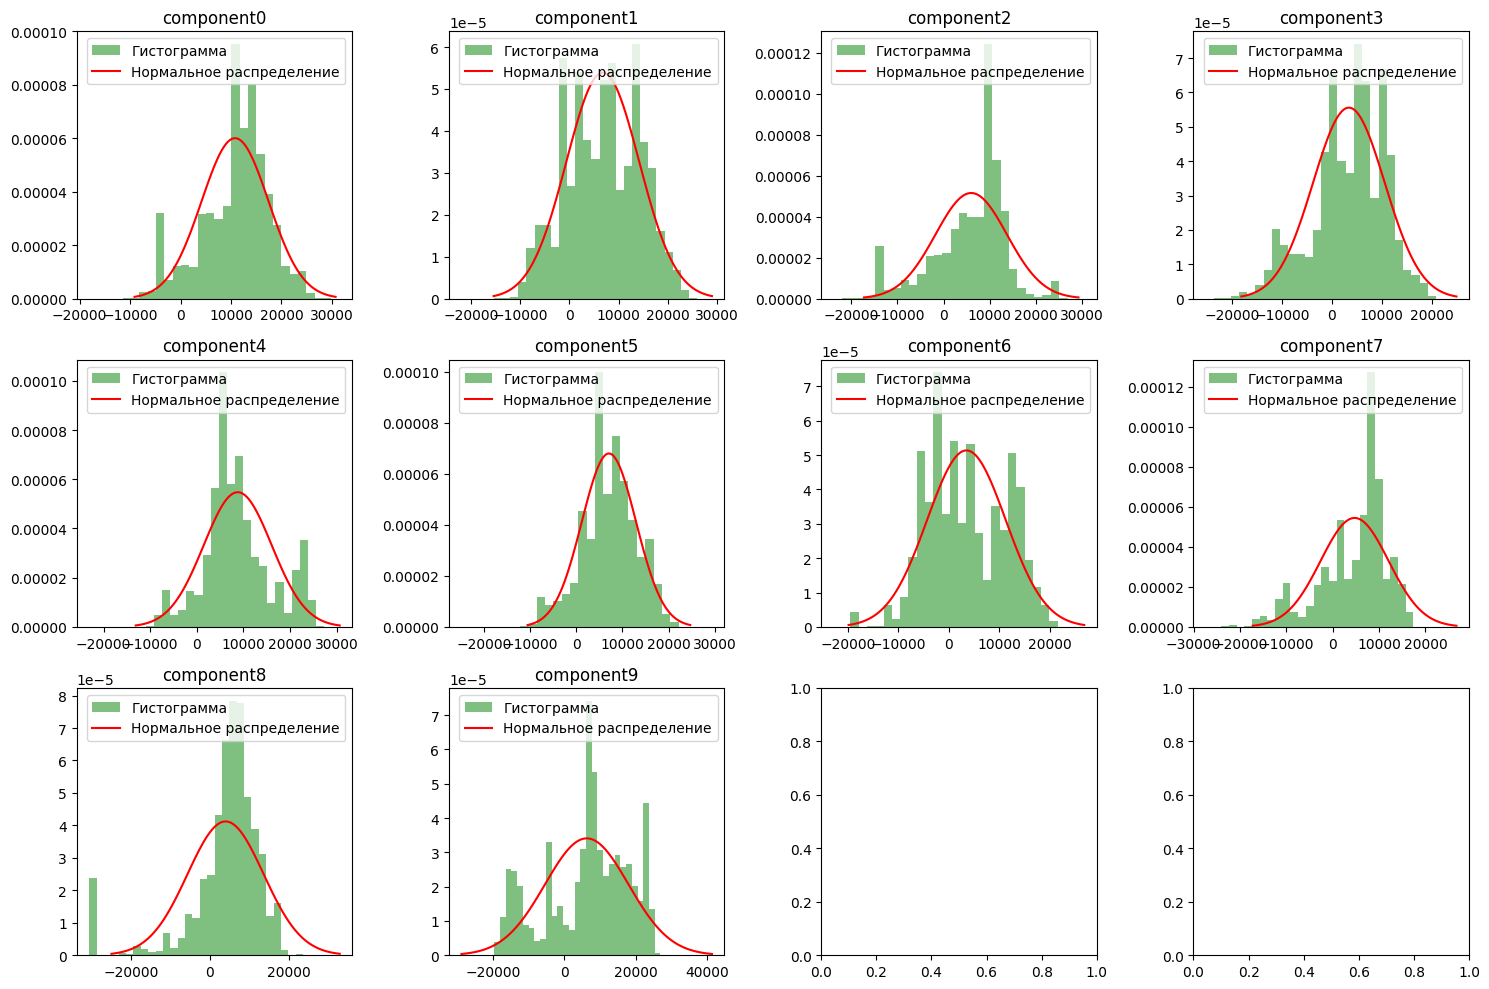

In [17]:
titles = ['component0', 'component1', 'component2', 'component3', 'component4', 'component5', 'component6', 'component7', 'component8', 'component9']
num_cols = 4
num_rows = math.ceil(len(titles) / num_cols)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))  
axs = axs.flatten()  

for i, column in enumerate(titles):
    name = column
    mean = train[name].mean()
    std_dev = train[name].std()
    x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
    pdf = stats.norm.pdf(x, mean, std_dev)
    ax = axs[i]
    # Создаем график
    ax.hist(train[name], bins=30, density=True, alpha=0.5, color='g', label='Гистограмма') 
    ax.plot(x, pdf, 'r-', label='Нормальное распределение')
    ax.legend()
    ax.set_title(name)

# Настройка макета
plt.tight_layout()
plt.show()


Видим, что большинство фичей имеют близкое к нормальному распределение

In [18]:
train["os"].value_counts()

os
Android          389999
Windows          136096
iOS               16752
Mac OS X           4434
Linux              2642
Tizen               561
Ubuntu               94
Chrome OS            60
Windows Phone        11
Other                 9
FreeBSD               5
Chromecast            5
Fedora                1
Name: count, dtype: int64

Большинство пользователей с андроида

In [19]:
train["os_version"].value_counts()

os_version
10         335740
13          53071
11          45048
12          34288
7           18211
            ...  
10.14.5         1
9.0.0           1
10.8.5          1
11.2.6          1
11.2.5          1
Name: count, Length: 221, dtype: int64

In [20]:
train["request_ts"].value_counts()

request_ts
1701021515    23
1701011971    23
1701005468    22
1701013208    22
1701000606    22
              ..
1700998890     1
1700949602     1
1700954858     1
1700955858     1
1700965825     1
Name: count, Length: 84135, dtype: int64

Это время запросов, однако оно зашифровано. Если бы были даны реальные даты, мы могли бы учитывать сезонность запросов

In [22]:
train["geo_id"].value_counts()

geo_id
3663    96689
2521    42388
4106    17541
8816    16090
1198    14008
        ...  
3100        1
9708        1
6215        1
4735        1
7546        1
Name: count, Length: 1969, dtype: int64

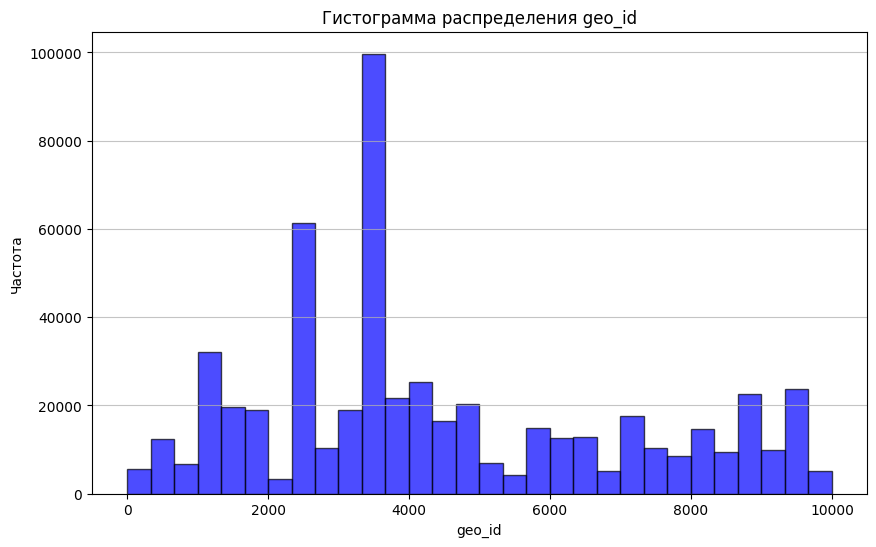

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(train['geo_id'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Гистограмма распределения geo_id')
plt.xlabel('geo_id')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()


# Выводы

In [ ]:
1. Большинство фичей распределены нормально, поэтому мы может на первом этапе обойтись без предобработки.
2. Нормальность распределение даёт нам возможность попробовать использование логистической регрессии, которая может здесь хорошо работать
3. Количество мужчин и женщин в таргете примерно одинаковое и мы может обойтись без использования методов для балансировки, таких как undersampling и over 